# Bounds on the Secrecy Outage Probability

_Author:_ Karl-Ludwig Besser, Technische Universität Braunschweig, Germany

This notebook is part of the paper "Bounds on the Secrecy Outage Probability for Dependent Fading Channels" ([doi:XXX](https://doi.org/XXX), [arXiv:XXX](https://arxiv.org/abs/XXX)).  
If you use any of this work, please cite the above paper.

> If you are not familiar with Jupyter notebooks: The easiest way to use this notebook interactively, is to hit `Kernel --> Restart & Run All` in the menu. The will execute all cells and enable the interactive elements of the plots.

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from ipywidgets import interact

# CSI-T about the Main Channel

In the case that the transmitter (Alice) has channel state information (CSI) about the main channel to the legitimate receiver, a secrecy outage occurs, if the instantaneous secrecy capacity $C_S$ is less than the secrecy rate $R_S$ used for the transmission. The secrecy outage probability $\varepsilon$ is then given as
$$\varepsilon = \Pr\left(\log_2(1+\rho_x X) - \log_2(1+\rho_y Y) < R_S\right),$$
with Bob's SNR $\rho_x$ and Eve's SNR $\rho_y$.

We can reformulate this as
$$\varepsilon = \Pr\left(\tilde{X}+\tilde{Y} < s\right)$$
with the variables $\tilde{X}=\rho_x X$, $\tilde{Y}=\rho_y Y$, and $s=2^{R_S}-1$.

In the following plots, we will assume Rayleigh fading for both channels, i.e., $X$ and $Y$ are exponentially distributed as $X\sim\exp(\lambda_x)$ and $Y\sim\exp(\lambda_y)$.

In [2]:
def plot_integration_area_main_csit():
    fig, axs = plt.subplots(num="Integration Area Main CSIT")
    x = np.linspace(0, 5)
    def update_plot(r_s):
        y = (2**r_s-1) - x
        axs.clear()
        axs.set_xlim([0, 5])
        axs.set_ylim([-5, 0])
        axs.set_xlabel("$\\tilde{x}$")
        axs.set_ylabel("$\\tilde{y}$")
        axs.plot(x, y)
        axs.fill_between(x, y, -5, alpha=.25)
    interact(update_plot, r_s=(.01, 1, .01))

The following plot shows the integration area corresponding to the secrecy outage, i.e., $\tilde{X}+\tilde{Y}<s$.

<IPython.core.display.Javascript object>


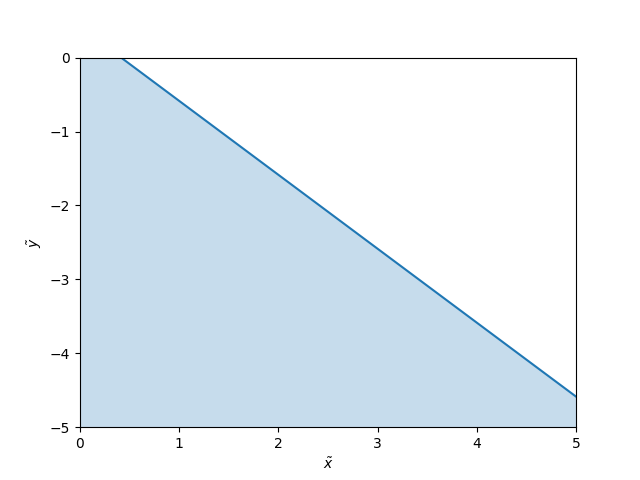

interactive(children=(FloatSlider(value=0.5, description='r_s', max=1.0, min=0.01, step=0.01), Output()), _dom…

In [3]:
plot_integration_area_main_csit()

In [4]:
from bounds_main_csit import lower_bound_main_csit, upper_bound_main_csit, independent_main_csit

In [5]:
def plot_vs_snrbob_main_csit():
    r_c = 0  # not needed when CSIT is available
    snr_db = np.arange(-5, 15.5, .5)
    snr_bob = 10**(snr_db/10)
    fig, axs = plt.subplots(num="Outage Probability vs SNR_Bob with Main CSIT")
    curves = {"Lower Bound": lower_bound_main_csit, "Upper Bound": upper_bound_main_csit, 
              "Independent Channels": independent_main_csit}
    plots = {k: axs.semilogy(snr_db, np.ones(len(snr_db)), label=k)[0] for k in curves.keys()}
    axs.set_ylim([1e-5, 1.1])
    axs.set_xlabel("SNR Bob $\\rho_x$ [dB]")
    axs.set_ylabel("Secrect Outage Probability $\\varepsilon$")
    axs.legend()
    def update_plot(snr_eve_db, lam_x, lam_y, r_s):
        snr_eve = 10**(snr_eve_db/10)
        lam_xt = lam_x/snr_bob
        lam_yt = lam_y/(snr_eve*2**r_s)
        #print(snr_db)
        #print(lam_xt>lam_yt)
        for _name, _func in curves.items():
            plots[_name].set_ydata(_func(r_s, r_c, lam_xt, lam_yt))
    interact(update_plot, snr_eve_db=(-10, 10, 1), lam_x=(0.5, 2, .1), lam_y=(0.5, 2, .1), r_s=(0.01, 0.5, 0.01))

The following plot shows the behavior of the secrecy outage probability $\varepsilon$ for varying SNR of Bob's channel $\rho_x$.  
The upper bound, lower bound, and the case of independent channels are plotted.

<IPython.core.display.Javascript object>


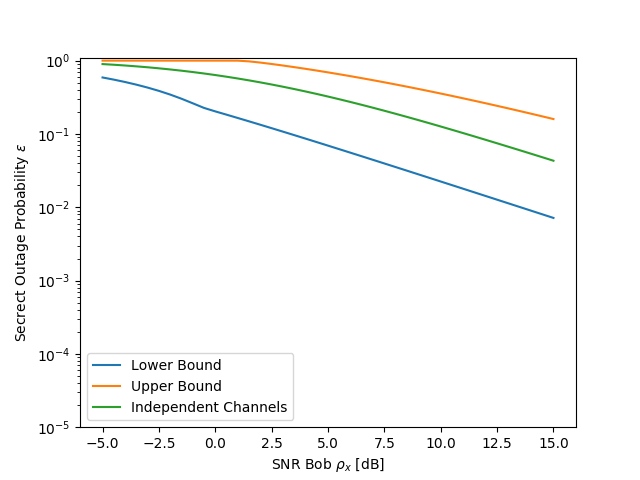

interactive(children=(IntSlider(value=0, description='snr_eve_db', max=10, min=-10), FloatSlider(value=1.20000…

In [6]:
plot_vs_snrbob_main_csit()

In [7]:
def plot_vs_snreve_main_csit():
    r_c = 0  # not needed when CSIT is available
    snr_db_eve = np.arange(-30, 15.5, .5)
    snr_eve = 10**(snr_db_eve/10)
    fig, axs = plt.subplots(num="Outage Probability vs SNR_Eve with Main CSIT")
    curves = {"lower": lower_bound_main_csit, "upper": upper_bound_main_csit, 
              "independent": independent_main_csit}
    plots = {k: axs.semilogy(snr_db_eve, np.ones(len(snr_db_eve)))[0] for k in curves.keys()}
    axs.set_ylim([1e-3, 1.1])
    axs.set_xlabel("SNR Eve $\\rho_y$ [dB]")
    axs.set_ylabel("Secrect Outage Probability $\\varepsilon$")
    def update_plot(snr_bob_db, lam_x, lam_y, r_s):
        snr_bob = 10**(snr_bob_db/10)
        lam_xt = lam_x/snr_bob
        lam_yt = lam_y/(snr_eve*2**r_s)
        #print(snr_db)
        #print(lam_xt>lam_yt)
        for _name, _func in curves.items():
            plots[_name].set_ydata(_func(r_s, r_c, lam_xt, lam_yt))
    interact(update_plot, snr_bob_db=(-10, 10, 1), lam_x=(0.5, 2, .1), lam_y=(0.5, 2, .1), r_s=(0.01, 0.5, 0.01))

The following plot shows the behavior of the secrecy outage probability $\varepsilon$ for varying SNR of Eve's channel $\rho_y$.  
The upper bound, lower bound, and the case of independent channels are plotted.

<IPython.core.display.Javascript object>


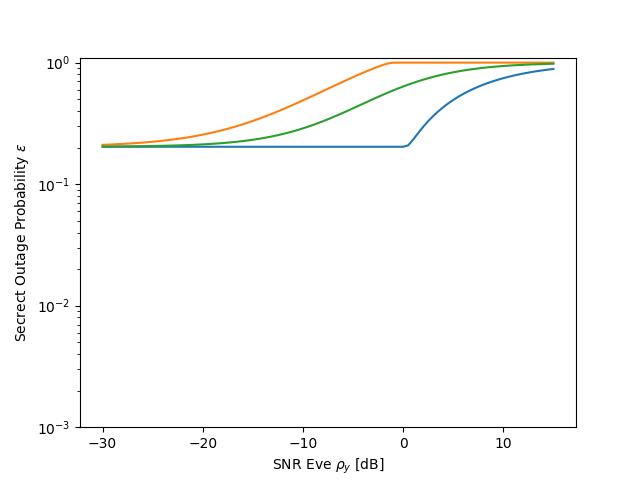

interactive(children=(IntSlider(value=0, description='snr_bob_db', max=10, min=-10), FloatSlider(value=1.20000…

In [8]:
plot_vs_snreve_main_csit()

In [9]:
def plot_vs_rs_main_csit():
    r_c = 0  # not needed when CSIT is available
    r_s = np.logspace(-3, 1, 40)
    fig, axs = plt.subplots(num="Outage Probability vs Rs with Main CSIT")
    curves = {"lower": lower_bound_main_csit, "upper": upper_bound_main_csit, 
              "independent": independent_main_csit}
    plots = {k: axs.loglog(r_s, np.ones(len(r_s)))[0] for k in curves.keys()}
    axs.set_ylim([1e-4, 1.1])
    axs.set_xlabel("Secrecy Rate $R_S$")
    axs.set_ylabel("Secrect Outage Probability $\\varepsilon$")
    def update_plot(snr_bob_db, snr_eve_db, lam_x, lam_y):
        snr_bob = 10**(snr_bob_db/10)
        snr_eve = 10**(snr_eve_db/10)
        lam_xt = lam_x/snr_bob
        lam_yt = lam_y/(snr_eve*2**r_s)
        #print(snr_db)
        #print(lam_xt>lam_yt)
        for _name, _func in curves.items():
            plots[_name].set_ydata(_func(r_s, r_c, lam_xt, lam_yt))
    interact(update_plot, snr_bob_db=(-10, 10, 1), snr_eve_db=(-10, 10, 1), lam_x=(0.5, 2, .1), lam_y=(0.5, 2, .1))

The following plot shows the behavior of the secrecy outage probability $\varepsilon$ for varying secrecy rates $R_S$.  
The upper bound, lower bound, and the case of independent channels are plotted.

An intereting behavior is that the lower bound approaches a positive value ($>0$) for $R_S\to 0$, if Eve's channel quality exceeds the quality of Bob's channel. One way to observe this behavior is to simply increase the value of Eve's SNR.

<IPython.core.display.Javascript object>


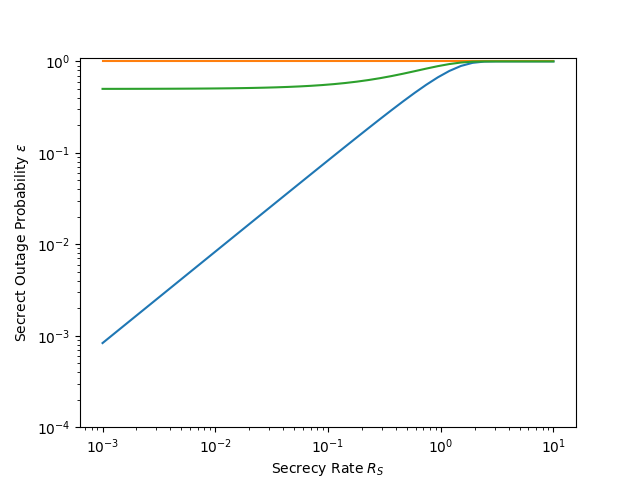

interactive(children=(IntSlider(value=0, description='snr_bob_db', max=10, min=-10), IntSlider(value=0, descri…

In [10]:
plot_vs_rs_main_csit()

## Optimal Distributions

In the above plots, the secrecy outage probabilities for the worst-case and best-case are shown.  
In the following, we give examples of joint distributions of $X$ and $Y$ that achieve these bounds.

In [11]:
def cdf_xt(x, lam=1):
    return np.maximum(1.-np.exp(-x*lam), 0)

def cdf_yt(y, lam=1):
    return np.minimum(np.exp(y*lam), 1)

def copula_lower(a, b, r_s=1, lam_xt=1, lam_yt=1):
    t = lower_bound_main_csit(r_s, 1, lam_xt, lam_yt)
    c = np.minimum(a, b)
    idx_t = np.where(np.logical_and(a >= t, b >= t))
    c[idx_t] = np.maximum(a[idx_t] + b[idx_t] - 1, t)
    return c

def copula_upper(a, b, r_s=1, lam_xt=1, lam_yt=1):
    r = upper_bound_main_csit(r_s, 1, lam_xt, lam_yt)
    c = np.minimum(a, b)
    idx_r = np.where(np.logical_and(a <= r, b <= r))
    c[idx_r] = np.maximum(a[idx_r] + b[idx_r] - r, 0)
    return c

In [12]:
from matplotlib.gridspec import GridSpec

def plot_joint_dist(copula, title):
    xlim = [0, 2]
    ylim = [0, 2]
    fig = plt.figure(num=title)
    gs = GridSpec(4,4)
    ax_joint = fig.add_subplot(gs[1:4,0:3])
    ax_marg_x = fig.add_subplot(gs[0,0:3])
    ax_marg_y = fig.add_subplot(gs[1:4,3])
    #ax_joint.set_xlabel("$\\tilde{X}$")
    ax_marg_x.xaxis.tick_top()
    ax_marg_y.yaxis.tick_right()
    x, stepx = np.linspace(*xlim, num=75, retstep=True)
    y, stepy = np.linspace(*ylim, num=75, retstep=True)
    X, Y = np.meshgrid(x, y)
    def update_plot(snr_bob_db=0, snr_eve_db=0, r_s=1, lam_x=1, lam_y=1):
        snr_bob = 10**(snr_bob_db/10)
        snr_eve = 10**(snr_eve_db/10)
        lam_xt = lam_x/snr_bob
        lam_yt = lam_y/(snr_eve*2**r_s)
        Xt = snr_bob*X
        Yt = -2**r_s*snr_eve*Y
        marg_cdf_xt = cdf_xt(Xt, lam=lam_xt)
        marg_cdf_yt = cdf_yt(Yt, lam=lam_yt)
        #marg_cdf_yt = cdf_xt(Y, lam=lam_yt)
        joint_cdf = copula(marg_cdf_xt, marg_cdf_yt, r_s=r_s, lam_xt=lam_xt, lam_yt=lam_yt)
        _gradx = np.gradient(joint_cdf, snr_bob*stepx, axis=0)
        joint_pdf = np.gradient(_gradx, -2**r_s*snr_eve*stepy, axis=1)
        marg_x = np.exp(-lam_x*x)  #marg_cdf_xt[0, :]
        marg_y = np.exp(-lam_y*y)  #marg_cdf_yt[:, 0]
        for _ax in [ax_joint, ax_marg_x, ax_marg_y]:
            _ax.clear()
        ax_marg_x.set_xlim(xlim)
        ax_marg_x.set_ylim([0, 1])
        ax_marg_y.set_xlim([0, 1])
        ax_marg_y.set_ylim(ylim)
        ax_joint.set_xlabel("$X$")
        ax_joint.set_ylabel("$Y$")
        ax_joint.pcolormesh(X, Y, joint_pdf, vmin=0)
        ax_marg_x.plot(x, marg_x)
        ax_marg_y.plot(marg_y, y)
        fig.canvas.draw_idle()
    interact(update_plot, snr_bob_db=(-5, 5), snr_eve_db=(-5, 5), r_s=(.1, 2, .1),
             lam_x=(.1, 3, .1), lam_y=(.1, 3., .1))
    #plt.colorbar()

First, the joint distribution for the lower bound (best-case) is shown.

The intuition behind this is that the high realizations of Eve's channel gain $Y$ always occur when Bob's channel gain $X$ is low. On the other hand, when $X$ is large, $Y$ is small and therefore only little outages occur.

<IPython.core.display.Javascript object>


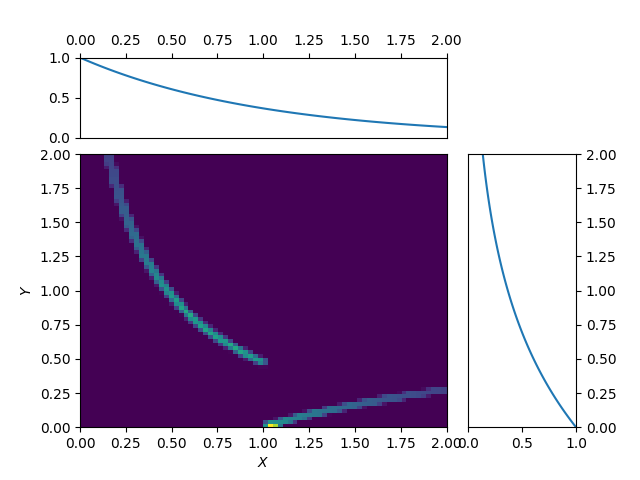

interactive(children=(IntSlider(value=0, description='snr_bob_db', max=5, min=-5), IntSlider(value=0, descript…

In [13]:
plot_joint_dist(copula_lower, "Joint Distribution Lower Bound")

Similarly, the joint distribution of the worst-case (upper bound) is shown next.

Try the following settings to observe "the full behavior":  

* SNR Bob: 5 dB
* SNR Eve: 5 dB
* R_S: 0.1
* $\lambda_x$: 0.5
* $\lambda_y$: 2.9

<IPython.core.display.Javascript object>


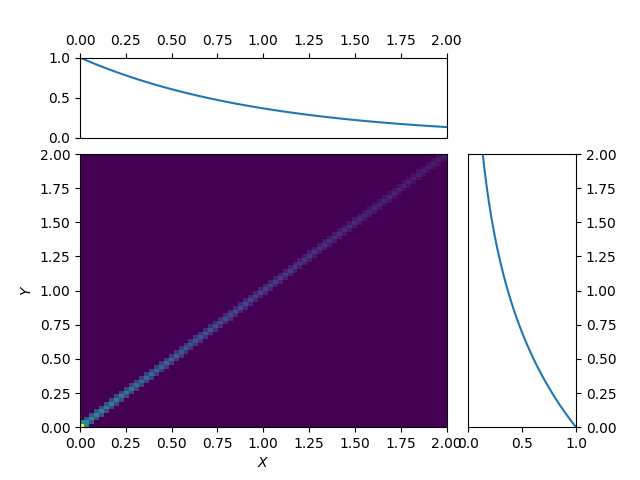

interactive(children=(IntSlider(value=0, description='snr_bob_db', max=5, min=-5), IntSlider(value=0, descript…

In [14]:
plot_joint_dist(copula_upper, "Joint Distribution Upper Bound")

For comparison, we also show  the joint distribution of independent $X$ and $Y$.

In [15]:
def plot_joint_independent():
    xlim = [0, 2]
    ylim = [0, 2]
    fig = plt.figure(num="Joint Distribution Independent Channels")
    gs = GridSpec(4,4)
    ax_joint = fig.add_subplot(gs[1:4,0:3])
    ax_marg_x = fig.add_subplot(gs[0,0:3])
    ax_marg_y = fig.add_subplot(gs[1:4,3])
    #ax_joint.set_xlabel("$\\tilde{X}$")
    #ax_joint.set_ylabel("$\\tilde{Y}$")
    ax_marg_x.xaxis.tick_top()
    ax_marg_y.yaxis.tick_right()
    x, stepx = np.linspace(*xlim, num=75, retstep=True)
    y, stepy = np.linspace(*ylim, num=75, retstep=True)
    X, Y = np.meshgrid(x, y)
    def update_plot(lam_x=1, lam_y=1):
        marg_pdf_x = np.exp(-lam_x*X)
        marg_pdf_y = np.exp(-lam_y*Y)
        joint_pdf = marg_pdf_x*marg_pdf_y
        marg_x = marg_pdf_x[0, :]
        marg_y = marg_pdf_y[:, 0]
        for _ax in [ax_joint, ax_marg_x, ax_marg_y]:
            _ax.clear()
        ax_marg_x.set_xlim(xlim)
        ax_marg_x.set_ylim([0, 1])
        ax_marg_y.set_xlim([0, 1])
        ax_marg_y.set_ylim(ylim)
        ax_joint.set_xlabel("$X$")
        ax_joint.set_ylabel("$Y$")
        ax_joint.pcolormesh(X, Y, joint_pdf, vmin=0)#, vmax=1)
        ax_marg_x.plot(x, marg_x)
        ax_marg_y.plot(marg_y, y)
        fig.canvas.draw_idle()
    interact(update_plot, lam_x=(.1, 3, .1), lam_y=(.1, 3., .1))
    #plt.colorbar()

<IPython.core.display.Javascript object>


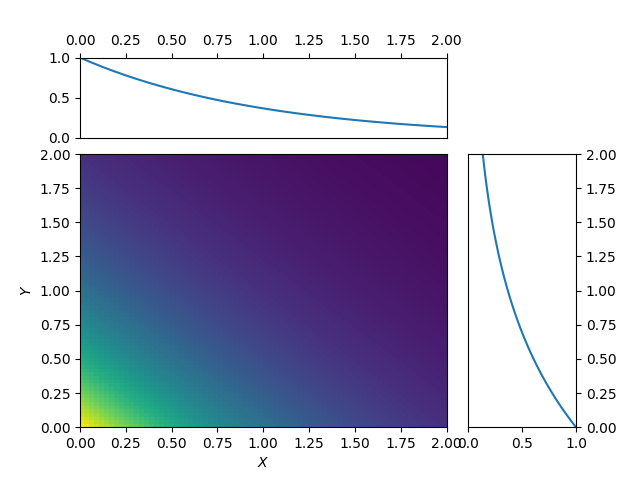

interactive(children=(FloatSlider(value=1.0, description='lam_x', max=3.0, min=0.1), FloatSlider(value=1.0, de…

In [16]:
plot_joint_independent()

# No CSI-T

After considering the scenario that the transmitter has perfect CSI about the main channel, we now consider the case that Alice has no CSI.

In this case, the outage probability is given as
$$\varepsilon = \Pr\left(\tilde{X}+\tilde{Y} < s \vee \tilde{X} < t\right)$$
with $t=2^{R_S+R_d}-1$.

In [17]:
def plot_integration_area_no_csit():
    fig, axs = plt.subplots(num="Integration Area No CSIT")
    y = np.linspace(-5, 0)
    def update_plot(r_s, r_c):
        x = np.maximum((2**r_s-1) - y, 2**(r_s+r_c)-1)
        axs.clear()
        axs.set_xlim([0, 5])
        axs.set_ylim([-5, 0])
        axs.set_xlabel("$\\tilde{x}$")
        axs.set_ylabel("$\\tilde{y}$")
        axs.plot(x, y)
        axs.fill_betweenx(y, x, 0, alpha=.25)
    interact(update_plot, r_s=(.01, 1, .01), r_c=(.01, 1, .01))

The area corresponding to the outage event is now a bit different from the one where CSIT is available. In particular, the outages due to Bob's decoding errors add the area $\tilde{X}<t$.

<IPython.core.display.Javascript object>


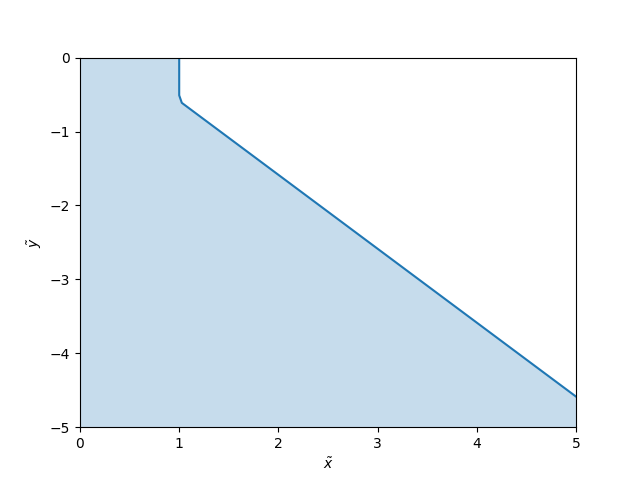

interactive(children=(FloatSlider(value=0.5, description='r_s', max=1.0, min=0.01, step=0.01), FloatSlider(val…

In [18]:
plot_integration_area_no_csit()

In [19]:
from bounds_no_csit import lower_bound_no_csit, upper_bound_no_csit, independent_no_csit

In [20]:
def plot_no_csit_bounds():
    snr_db = np.arange(-5, 21, 0.5)
    snr_bob = 10**(snr_db/10)
    curves = {"Lower Bound": lower_bound_no_csit,
              "Upper Bound": upper_bound_no_csit,
              "Independent Case": independent_no_csit}
    fig, ax = plt.subplots(num="Outage Probability vs SNR_Bob without CSIT")
    plots = {k: ax.semilogy(snr_db, np.ones(len(snr_db)), label=k)[0] for k in curves.keys()}
    ax.set_xlabel("SNR Bob $\\rho_x$ [dB]")
    ax.set_ylabel("Outage Probability $\\varepsilon$")
    ax.set_ylim([0.01, 1.1])
    fig.legend()
    def update_plot(snr_eve_db, r_s, r_c, lam_x, lam_y):
        snr_eve = 10**(snr_eve_db/10)
        lam_xt = lam_x/snr_bob
        lam_yt = lam_y/(snr_eve*2**r_s)
        for _name, _func in curves.items():
            plots[_name].set_ydata(_func(r_s, r_c, lam_xt, lam_yt))
    interact(update_plot, snr_eve_db=(-5, 10), r_s=(0.01, 2, 0.01), r_c=(0.01, 2, 0.01),
             lam_x=(0.01, 3, 0.03), lam_y=(0.01, 3, 0.03))
    plt.show()

The following plot shows the behavior of the secrecy outage probability $\varepsilon$ for varying SNR of Bob's channel $\rho_x$.  
The upper bound, lower bound, and the case of independent channels are plotted.

<IPython.core.display.Javascript object>


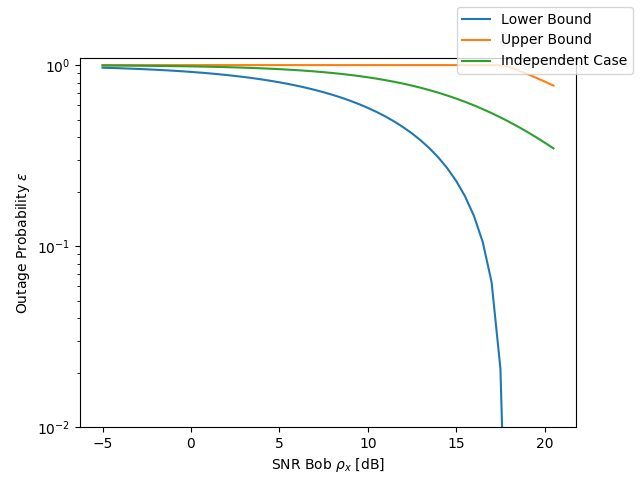

interactive(children=(IntSlider(value=2, description='snr_eve_db', max=10, min=-5), FloatSlider(value=1.0, des…

In [21]:
plot_no_csit_bounds()

In [26]:
def limits_rs_zero_no_csit(r_c, lam_x, lam_y, snr_x, snr_y, curve):
    lam_xt = lam_x/snr_x
    lam_yt = lam_y/snr_y
    t = 2**r_c - 1
    curve = curve.lower()
    if curve.startswith("low"):
        _limit = _limit_rs_zero_no_csit_lower(t, lam_xt, lam_yt)
    elif curve.startswith("up"):
        _limit = _limit_rs_zero_no_csit_upper(t, lam_xt, lam_yt)
    elif curve.startswith("ind"):
        _limit = _limit_rs_zero_no_csit_indep(t, lam_xt, lam_yt)
    else:
        _limit = NotImplemented
    return _limit

def _limit_rs_zero_no_csit_lower(t, lam_xt, lam_yt):
    if lam_xt == lam_yt:
        yt_star = -1/lam_xt
    else:
        yt_star = np.log(lam_yt/lam_xt)/(lam_xt-lam_yt)
    out_bob = 1.-np.exp(-lam_xt*t)
    out_all = np.exp(lam_yt*yt_star) - np.exp(lam_xt*yt_star)
    return np.maximum(out_bob, out_all)

def _limit_rs_zero_no_csit_upper(t, lam_xt, lam_yt):
    if lam_xt >= lam_yt:
        out = 1
    else:
        yt_star = np.log(lam_yt/lam_xt)/(lam_xt-lam_yt)
        yt_star = np.minimum(-t, yt_star)
        out = 1 - np.exp(lam_xt*yt_star) + np.exp(lam_yt*yt_star)
    return out

def _limit_rs_zero_no_csit_indep(t, lam_xt, lam_yt):
    return 1 - np.exp(-lam_xt*t) + (lam_xt*np.exp(-(lam_yt+lam_xt)*t))/(lam_xt + lam_yt)


def plot_vs_rs_no_csit():
    r_s = np.logspace(-3, 1, 40)
    fig, axs = plt.subplots(num="Outage Probability vs Rs without CSIT")
    curves = {"Lower Bound": lower_bound_no_csit, "Upper Bound": upper_bound_no_csit, 
              "Independent Case": independent_no_csit}
    plots = {k: axs.loglog(r_s, np.ones(len(r_s)), label=k)[0] for k in curves.keys()}
    limit_plots = {k: axs.loglog([min(r_s), 1], [1, 1], '--', color=plots[k].get_color())[0] for k in curves.keys()}
    axs.set_ylim([1e-3, 1.1])
    axs.set_xlabel("Secrecy Rate $R_S$")
    axs.set_ylabel("Secrect Outage Probability $\\varepsilon$")
    fig.legend()
    def update_plot(snr_bob_db, snr_eve_db, lam_x, lam_y, r_c):
        snr_bob = 10**(snr_bob_db/10)
        snr_eve = 10**(snr_eve_db/10)
        lam_xt = lam_x/snr_bob
        lam_yt = lam_y/(snr_eve*2**r_s)
        #print(snr_db)
        #print(lam_xt>lam_yt)
        for _name, _func in curves.items():
            plots[_name].set_ydata(_func(r_s, r_c, lam_xt, lam_yt))
            limit_plots[_name].set_ydata(limits_rs_zero_no_csit(r_c, lam_x, lam_y, snr_bob, snr_eve, _name))
    interact(update_plot, snr_bob_db=(-10, 10, 1), snr_eve_db=(-10, 10, 1), lam_x=(0.5, 2, .1),
             lam_y=(0.5, 2, .1), r_c=(0.05, 1, .01))

<IPython.core.display.Javascript object>


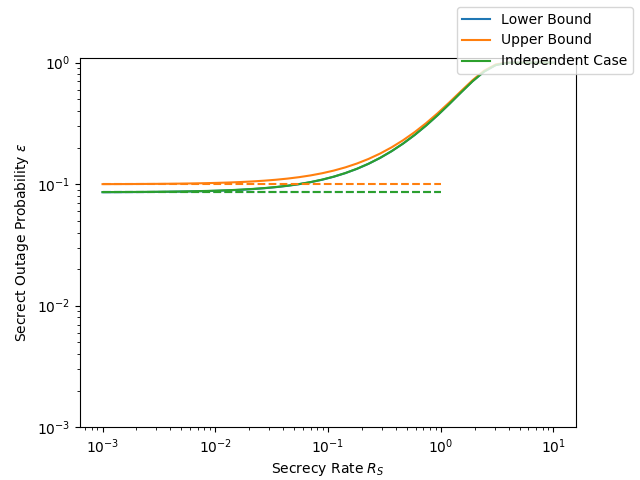

interactive(children=(IntSlider(value=0, description='snr_bob_db', max=10, min=-10), IntSlider(value=0, descri…

In [27]:
plot_vs_rs_no_csit()

# Comparison No CSIT vs Main CSIT

In [24]:
def plot_comparison_bounds():
    snr_db = np.arange(-5, 16, 0.1)
    snr_bob = 10**(snr_db/10)
    curves = {"Lower - No CSIT": lower_bound_no_csit,
              "Upper - No CSIT": upper_bound_no_csit,
              "Indep - No CSIT": independent_no_csit,
              "Lower - Main CSIT": lower_bound_main_csit,
              "Upper - Main CSIT": upper_bound_main_csit,
              "Indep - Main CSIT": independent_main_csit}
    fig, ax = plt.subplots(num="Outage Probability vs SNR_Bob with and without CSIT")
    plots = {k: ax.semilogy(snr_db, np.ones(len(snr_db)), label=k)[0] for k in curves.keys()}
    ax.set_xlabel("SNR Bob $\\rho_x$ [dB]")
    ax.set_ylabel("Outage Probability $\\varepsilon$")
    ax.set_ylim([0.001, 1.1])
    ax.legend()
    def update_plot(snr_eve_db, r_s, r_c, lam_x, lam_y):
        snr_eve = 10**(snr_eve_db/10)
        lam_xt = lam_x/snr_bob
        lam_yt = lam_y/(snr_eve*2**r_s)
        for _name, _func in curves.items():
            plots[_name].set_ydata(_func(r_s, r_c, lam_xt, lam_yt))
    interact(update_plot, snr_eve_db=(-5, 10), r_s=(0.01, 2, 0.01), r_c=(0.01, 2, 0.01),
             lam_x=(0.01, 3, 0.03), lam_y=(0.01, 3, 0.03))
    plt.show()

The following plot shows the behavior of the secrecy outage probability $\varepsilon$ with and without CSIT for varying SNR of Bob's channel $\rho_x$.  
The upper bound, lower bound, and the case of independent channels are plotted.

<IPython.core.display.Javascript object>


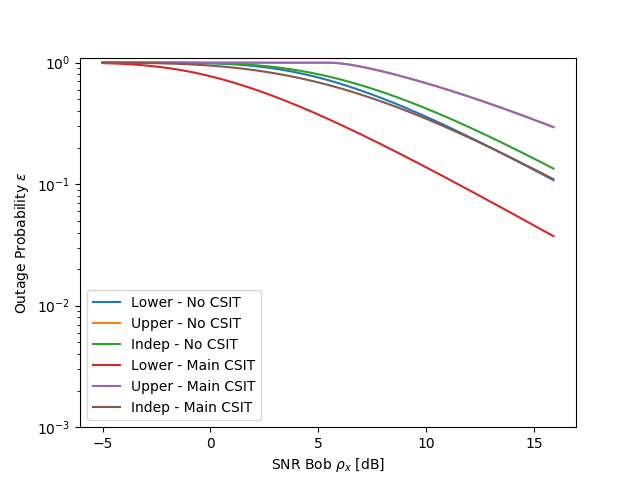

interactive(children=(IntSlider(value=2, description='snr_eve_db', max=10, min=-5), FloatSlider(value=1.0, des…

In [25]:
plot_comparison_bounds()